In [1]:
import numpy as np
from numba import jit 
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
def d1(S, K, T, r, sigma):
    
    return (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))

def d2(S, K, T, r, sigma):
    
    return d1(S, K, T, r, sigma) - sigma * np.sqrt(T)

def bs_call(S, K, T, r, sigma):
    
    return S * norm.cdf(d1(S, K, T, r, sigma)) - K * np.exp(-r * T) * norm.cdf(d2(S, K, T, r, sigma))

def bs_put(S, K, T, r, sigma):
    
    return K * np.exp(-r * T) * norm.cdf(-d2(S, K, T, r, sigma)) - S * norm.cdf(-d1(S, K, T, r, sigma))

# <center> Stopping Times </center> 

In [3]:
@jit(nopython = True)
def get_optimal_stopping_time():
    
    # Setting Parameters
    T = 3 
    S0 = 100
    r = 0.02 
    sigma = 0.3
    
    # Stopping Time Threshold
    L = 105
    
    # Iteration Variables
    N =  100
    count = 100000
    dt = T / N
    arrT = np.zeros(count)
    arrS = np.zeros(count)
    
    # Monte Carlo
    for i in range(count):
    
        stock_process = np.zeros(N)
        rv = np.random.normal(0, 1, N)

        B = np.cumsum(rv * np.sqrt(dt))
        stock_process = 100 * np.exp((r - 0.5 * sigma**2) * dt + sigma * B)
        
        for j in range(N):
            
            if stock_process[j] > L:
                stock_process[j] = L     # Assume Continuity
                break
        
        arrT[i] = j
        arrS[i] = stock_process[j]
        
    return arrT, arrS

Average Stopping Time:  21.68425


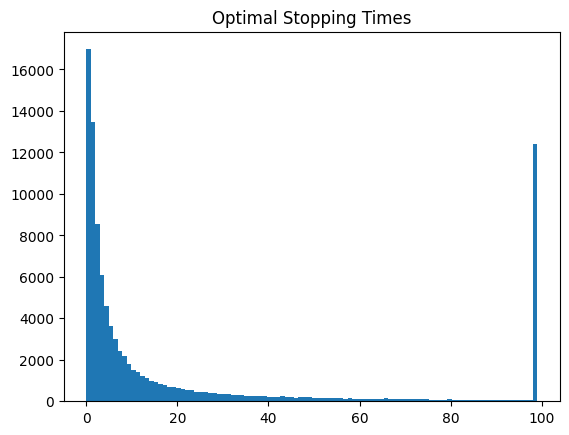

In [4]:
stopping_times, stop_price = get_optimal_stopping_time()
avg_time = np.mean(stopping_times)
print("Average Stopping Time: ", avg_time)

plt.hist(stopping_times, bins = 100)
plt.title("Optimal Stopping Times")
plt.show()

In [5]:
N = len(stop_price)
avg = np.zeros(N)
payoff = np.zeros(N)

for i in range(N):

    avg[i] = np.exp(-0.02 * stopping_times[i] / 365) * stop_price[i]
    payoff[i] = np.exp(-0.02 * stopping_times[i] / 365) * np.maximum(stop_price[i] - 100, 0)

print("Monte Carlo Result: ", np.mean(avg))
print("\n")

print("Monte Carlo Price: ", np.mean(payoff))

analytical = bs_call(100, 100, avg_time / 365, 0.02, 0.3)
print("Black Scholes Price: ", analytical)

Monte Carlo Result:  99.28719578770668


Monte Carlo Price:  4.382963925332448
Black Scholes Price:  2.9745156472881007


## The optional sampling theorem is reasonably close. 

## The monte carlo price is not close to the Black Scholes call option price. 

## I expected the monte carlo price to be higher because more options will get exercised since the level is only 105. This should skew the distribution. When I increase the level, the price goes up.  

# <center> Perpetual Put </center> 

# <center> $L^{*} = \frac{2 r K}{2r + \sigma^{2}} $ </center> 

In [6]:
def get_L_star(K, r, sigma):
    
    return (2 * r * K) / (2 * r + sigma**2) 

In [7]:
get_L_star(105, 0.02, 0.3)

32.30769230769231

# <center> $ A = \frac{\sigma^{2}}{2r} \cdot L^{\frac{2r}{\sigma^{2}} + 1} $ </center> 

In [8]:
def get_A(K, r, sigma):
    
    return (sigma**2 / 2 * r) * get_L_star(K, r, sigma) * ((2 * r / sigma**2) + 1)

In [9]:
def perpetual_put():

    r = 0.02
    sigma = 0.3
    K = 105
    N = 100
    X = np.linspace(80, 120, 100)
    payoff = np.maximum(K - X, 0)
    puts = np.zeros(N)

    for i in range(N):
        puts[i] = get_A(K, r, sigma) * X[i]**(-2 * r / sigma**2)
    
    return puts, payoff

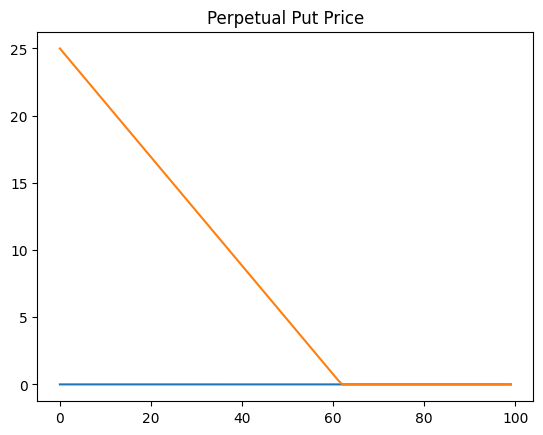

In [10]:
puts, payoff = perpetual_put()

plt.plot(puts)
plt.plot(payoff)
plt.title("Perpetual Put Price")
plt.show()

## Getting weird results, I do not see the typo. I am going to use Wikipedia solution. It should still yield the same solution. 

# <center> From Wikipedia </center> 

## <center> https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model </center> 

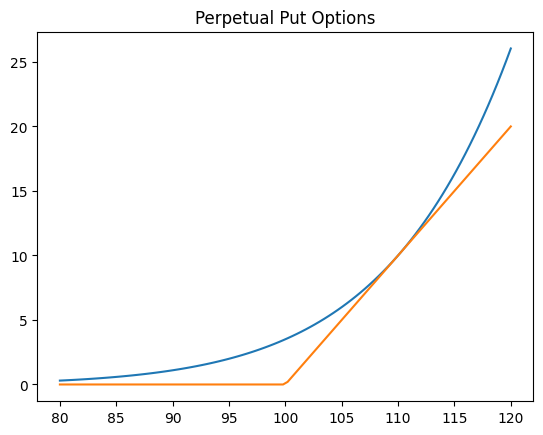

In [11]:
r = 0.05
sigma = 0.1

# From Wikipedia
l1 = (-(r - 0.5 * sigma**2) + np.sqrt((r - 0.5 * sigma**2)**2 + (2 * sigma**2 * r))) / sigma**2
l2 = (-(r - 0.5 * sigma**2) - np.sqrt((r - 0.5 * sigma**2)**2 + (2 * sigma**2 * r))) / sigma**2

K = np.linspace(80, 120, 100)
S = 100
payoff = np.maximum(K - S, 0)

V = (K / (1 - l2)) * ((l2 - 1) / l2)**(l2) * (S / K)**l2

plt.plot(K, V)
plt.plot(K, payoff)
plt.title("Perpetual Put Options")
plt.show()

## The perpetual put is larger than the payoff value when greater than 115 or less than 110 range. 

In [12]:
def get_vx(VN, V1, epsilon):
   
    return (V1 - VN) / epsilon

def get_vxx(VN, V1, V2, epsilon):
    
    return (V2 - (2 * V1) + VN) / epsilon**2

def pde():
    
    r = 0.05
    sigma = 0.1

    # From Wikipedia
    l1 = (-(r - 0.5 * sigma**2) + np.sqrt((r - 0.5 * sigma**2)**2 + (2 * sigma**2 * r))) / sigma**2
    l2 = (-(r - 0.5 * sigma**2) - np.sqrt((r - 0.5 * sigma**2)**2 + (2 * sigma**2 * r))) / sigma**2

    K = 105
    epsilon = 1e-3
    S = np.linspace(80, 120, 100)
    S1 = S + epsilon
    S2 = S + 2 * epsilon
    
    VN = (K / (1 - l2)) * ((l2 - 1) / l2)**(l2) * (S / K)**l2
    V1 = (K / (1 - l2)) * ((l2 - 1) / l2)**(l2) * (S1 / K)**l2
    V2 = (K / (1 - l2)) * ((l2 - 1) / l2)**(l2) * (S2 / K)**l2
    
    vx = get_vx(VN, V1, epsilon)
    vxx = get_vxx(VN, V1, V2, epsilon)
    
    return (r * VN) - (vx * r * S) - (0.5 * vxx * sigma**2 * S**2)

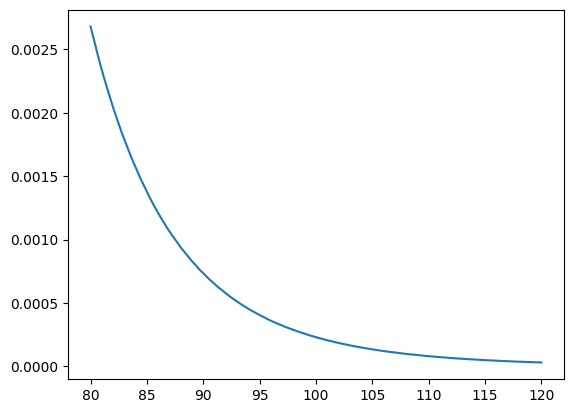

In [13]:
X = np.linspace(80, 120, 100)
data = pde()
plt.plot(X, data)
plt.show()

# All values are close to zero 

# <center> Black Scholes Put Option </center> 

In [14]:
@jit(nopython = True)
def get_black_scholes_put():
    
    T = 3
    S0 = 100
    r = 0.05 
    sigma = 0.1 
    K = 105
    L = 95
    
    N =  100
    count = 100000
    dt = T / N
    arrS = np.zeros(count)
    arrT = np.zeros(count)
    
    for i in range(count):
    
        stock_process = np.zeros(N)
        rv = np.random.normal(0, 1, N)

        B = np.cumsum(rv * np.sqrt(dt))
        stock_process = 100 * np.exp((r - 0.5 * sigma**2) * dt + sigma * B)
        
        for j in range(N):
            
            if stock_process[j] < L:
                stock_process[j] = L
                break
        
        arrS[i] = stock_process[j]
        arrT[i] = j
        
    return arrS, arrT

In [15]:
stopping_price, stop_time = get_black_scholes_put()
avg_time = np.mean(stop_time)
print("Average Stopping Time: ", avg_time)
print("\n")

N = len(stop_time)
avg = np.zeros(N)
for i in range(N):
    avg[i] = np.exp(-0.05 * stop_time[i] / 365) * np.maximum(105 - stopping_price[i], 0)
    
print("Monte Carlo Price: ", np.mean(avg))
print("\n")

analytical = bs_put(100, 105, avg_time / 365, 0.05, 0.1)
print("Black Scholes Price: ", analytical)

Average Stopping Time:  45.05733


Monte Carlo Price:  7.3318727381199595


Black Scholes Price:  4.54994524647347


## The Monte Carlo Price is bigger. 

## This is as expected. 

# <center> Perpetual Put Optimal Stopping Times </center> 

In [16]:
r = 0.05
sigma = 0.1
l1 = (-(r - 0.5 * sigma**2) + np.sqrt((r - 0.5 * sigma**2)**2 + 2 * sigma**2 * r)) / sigma**2
l2 = (-(r - 0.5 * sigma**2) - np.sqrt((r - 0.5 * sigma**2)**2 + 2 * sigma**2 * r)) / sigma**2
K = 120
S = 100
payoff = np.maximum(K - S, 0)

V = (K / (1 - l2)) * ((l2 - 1) / l2)**(l2) * (S / K)**l2
V

26.041990118975274

In [61]:
@jit(nopython = True)
def get_optimal_perpetual_stopping_time():
    
    # Setting Parameters
    S0 = 100
    r = 0.05 
    sigma = 0.1
    K = 120
    T = 100
    
    # Iteration Variables
    N =  100
    count = 100000
    dt = T / N
    arrT = np.zeros(count)
    arrS = np.zeros(count)
    
    l1 = (-(r - 0.5 * sigma**2) + np.sqrt((r - 0.5 * sigma**2)**2 + 2 * sigma**2 * r)) / sigma**2
    l2 = (-(r - 0.5 * sigma**2) - np.sqrt((r - 0.5 * sigma**2)**2 + 2 * sigma**2 * r)) / sigma**2
    
    # Monte Carlo
    for i in range(count):
    
        stock_process = np.zeros(N)
        rv = np.random.normal(0, 1, N)

        B = np.cumsum(rv * np.sqrt(dt))
        stock_process = 100 * np.exp((r - 0.5 * sigma**2) * dt + sigma * B)
        
        for j in range(N):
            
            L = np.maximum(K - stock_process[j], 0)
            V = (K / (1 - l2)) * ((l2 - 1) / l2)**(l2) * (S / K)**l2
            
            if L > V:
                stock_process[j] = L     # Assume Continuity
                break
        
        arrT[i] = j
        arrS[i] = stock_process[j]
        
    return arrT, arrS

In [62]:
stop_times, stop_prices = get_optimal_perpetual_stopping_time()

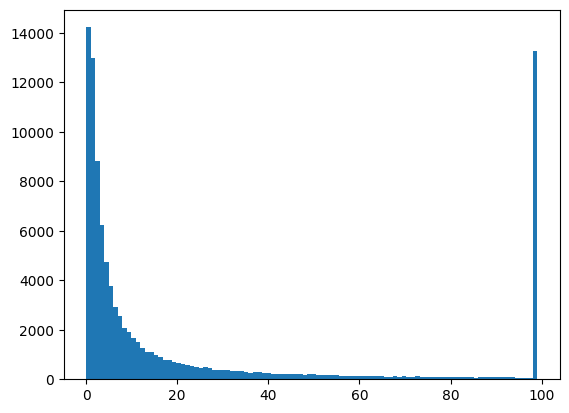

In [63]:
plt.hist(stop_times, bins = 100)
plt.show()

In [20]:
L_star = get_L_star(120, 0.01, 0.1)
L_star

79.99999999999999

In [21]:
S = 100
K = 120
l1 = (-(r - 0.5 * sigma**2) + np.sqrt((r - 0.5 * sigma**2)**2 + 2 * sigma**2 * r)) / sigma**2
l2 = (-(r - 0.5 * sigma**2) - np.sqrt((r - 0.5 * sigma**2)**2 + 2 * sigma**2 * r)) / sigma**2
V = (K / (1 - l2)) * ((l2 - 1) / l2)**(l2) * (S / K)**l2
V

26.041990118975274

In [54]:
def last_monte_carlo():
    
    # Setting Parameters
    S0 = 100
    r = 0.05 
    sigma = 0.1
    K = 120
    T = 25
    
    # Iteration Variables
    N =  100
    count = 100000
    dt = T / N
    arrT = np.zeros(count)
    arrS = np.zeros(count)
    
    l1 = (-(r - 0.5 * sigma**2) + np.sqrt((r - 0.5 * sigma**2)**2 + 2 * sigma**2 * r)) / sigma**2
    l2 = (-(r - 0.5 * sigma**2) - np.sqrt((r - 0.5 * sigma**2)**2 + 2 * sigma**2 * r)) / sigma**2
    
    L = get_L_star(120, 0.01, 0.1)
    print(L)
    
    # Monte Carlo
    for i in range(count):
    
        stock_process = np.zeros(N)
        rv = np.random.normal(0, 1, N)

        B = np.cumsum(rv * np.sqrt(dt))
        stock_process = 100 * np.exp((r - 0.5 * sigma**2) * dt + sigma * B)
        
        for j in range(N):
                        
            if stock_process[j] < L:
                stock_process[j] = L     # Assume Continuity
                break
        
        arrT[i] = j
        arrS[i] = stock_process[j]
        
    return arrT, arrS

In [55]:
stop_times, stop_prices = last_monte_carlo()

79.99999999999999


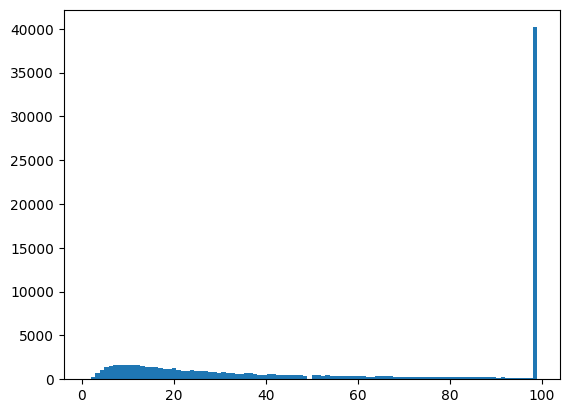

In [56]:
plt.hist(stop_times, bins = 100)
plt.show()

In [57]:
N = len(stop_times)
avg = np.zeros(N)
for i in range(N):
    
    avg[i] = np.exp(-0.02 * stop_times[i] / 365) * np.maximum(120 - stop_prices[i], 0)
    
print(np.mean(avg))

25.88115482165826


## These prices are decently close